In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal
from IPython import display
import time

In [106]:
file = open("faithful.dat.txt", 'r')

col_names = file.readline().strip().split(' ')
data = []
for line in file:
    data.append(line.split()[1:])
    
data = np.array(data).astype(float)

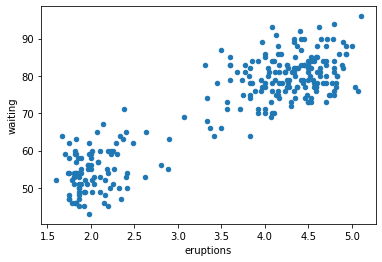

In [76]:
df = pd.DataFrame(data, columns=col_names)
df.plot.scatter(col_names[0], col_names[1])
plt.show()

1. Take initial guess on parameters

In [160]:
theta = {
    "pi" : 0.5,
    "mu0" : np.array((random.uniform(df.eruptions.min(),df.eruptions.max()),random.uniform(df.waiting.min(),df.waiting.max()))),
    "mu1" : np.array((random.uniform(df.eruptions.min(),df.eruptions.max()),random.uniform(df.waiting.min(),df.waiting.max()))),
    "std0" : np.array((random.uniform(0,df.eruptions.var()),random.uniform(0,df.waiting.var()))),
    "std1" : np.array((random.uniform(0,df.eruptions.var()),random.uniform(0,df.waiting.var())))
}
print(theta)

{'pi': 0.5, 'mu0': array([ 2.8770982 , 84.52952386]), 'mu1': array([ 3.63111424, 85.94613217]), 'std0': array([0.86179504, 1.82126676]), 'std1': array([0.18406663, 5.80243387])}


2. Find best guess for cluster membership, assuming theta

In [304]:
def norm_pdf(x, mu, var):
    return multivariate_normal.pdf(x,mu,var, allow_singular=True)

def E_step(data, theta):
    n_rows = data.shape[0]
    y_pred = np.empty(n_rows)
    for i in range(n_rows):
        numerator = theta["pi"] * norm_pdf(data[i], theta["mu1"], theta["var1"])
        denominator = numerator + (1-theta["pi"]) * norm_pdf(data[i], theta["mu0"], theta["var0"])
        y_pred[i] = numerator / denominator
    return y_pred

3. Do MLE pretending that $Y_i = \hat{Y}_i$

In [308]:
def M_step(y_pred, theta):
    theta["pi"] = y_pred.sum()/data.shape[0]
    theta["mu1"] = (y_pred[:,None]*data).sum(axis=0)/y_pred.sum()
    theta["var1"] = (y_pred[:,None]*(data-theta["mu1"])**2).sum(axis=0)/y_pred.sum()
    theta["mu0"] = ((1-y_pred)[:,None]*data).sum(axis=0)/(1-y_pred).sum()
    theta["var0"] = ((1-y_pred)[:,None]*(data-theta["mu0"])**2).sum(axis=0)/(1-y_pred).sum()
    return theta

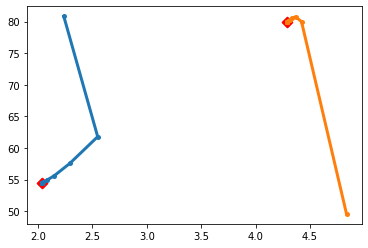

{'pi': 0.35651673625471003, 'mu0': array([ 4.29107049, 79.98562155]), 'mu1': array([ 2.03791567, 54.49295375]), 'var0': array([ 0.16815112, 35.77335124]), 'var1': array([ 0.07033675, 33.75584632])}


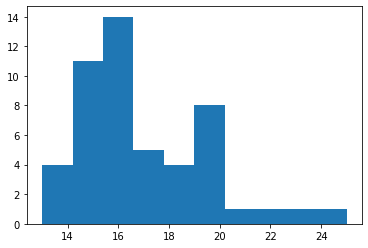

In [324]:
n_iters = []
for run in range(50):
    var = np.array((random.uniform(0,df.eruptions.var()),random.uniform(0,df.waiting.var())))
    theta = {
            "pi" : 0.5,
            "mu0" : np.array((random.uniform(df.eruptions.min(),df.eruptions.max()),random.uniform(df.waiting.min(),df.waiting.max()))),
            "mu1" : np.array((random.uniform(df.eruptions.min(),df.eruptions.max()),random.uniform(df.waiting.min(),df.waiting.max()))),
            "var0" : var,
            "var1" : var
        }
    mu0 = [theta["mu0"]]
    mu1 = [theta["mu1"]]
    terminate = False
    i=0
    while not terminate:
        y_pred = E_step(data, theta)
        plt.plot(list(zip(*mu1))[0],list(zip(*mu1))[1],linewidth=3,marker="o",markersize=2,mew=3)
        plt.plot(list(zip(*mu0))[0],list(zip(*mu0))[1],linewidth=3,marker="o",markersize=2,mew=3)
        plt.scatter([theta["mu0"][0],theta["mu1"][0]],[theta["mu0"][1],theta["mu1"][1]],c="r",marker='x',linewidths=8)
        display.clear_output(wait=True)
        plt.show()
        
        theta = M_step(y_pred, theta)
        print(theta)
        mu0.append(theta["mu0"])
        mu1.append(theta["mu1"])
        terminate = len(mu0) > 1 and mu0[-2][0] == mu0[-1][0] and mu0[-2][1] == mu0[-1][1] or theta["pi"] == 0 or theta["pi"] == 1
        i += 1
    n_iters.append(i)

    mu0 = np.array(mu0)
    mu1 = np.array(mu1)

plt.hist(n_iters)
plt.show()

In [271]:
from sklearn.cluster import KMeans

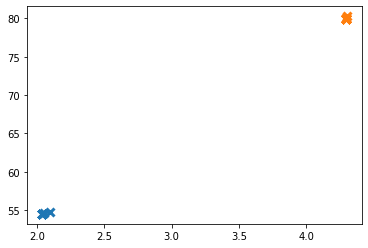

{'pi': 0.35651673625471003, 'mu0': array([ 4.29107049, 79.98562155]), 'mu1': array([ 2.03791567, 54.49295375]), 'var0': array([ 0.16815112, 35.77335124]), 'var1': array([ 0.07033675, 33.75584632])}


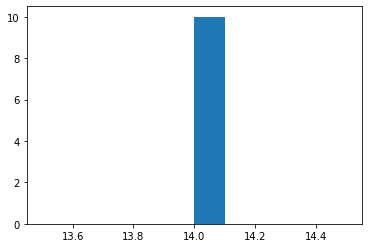

In [314]:
n_iters = []
for run in range(10):
    kmeans = KMeans(n_clusters=2, n_init=1)
    kmeans.fit(data)
    kmeans.labels_
    var = np.array((random.uniform(0,df.eruptions.var()),random.uniform(0,df.waiting.var())))
    theta = M_step(kmeans.labels_, theta)
    mu0 = [theta["mu0"]]
    mu1 = [theta["mu1"]]
    terminate = False
    i=0
    while not terminate:
        y_pred = E_step(data, theta)
        plt.plot(list(zip(*mu1))[0],list(zip(*mu1))[1],marker='x',linewidth=3,markersize=8,mew=3)
        plt.plot(list(zip(*mu0))[0],list(zip(*mu0))[1],marker='x',linewidth=3,markersize=8,mew=3)

        display.clear_output(wait=True)
        plt.show()
        
        theta = M_step(y_pred, theta)
        print(theta)
        mu0.append(theta["mu0"])
        mu1.append(theta["mu1"])
        terminate = len(mu0) > 1 and mu0[-2][0] == mu0[-1][0] and mu0[-2][1] == mu0[-1][1] or theta["pi"] == 0 or theta["pi"] == 1
        i += 1
    n_iters.append(i)

    mu0 = np.array(mu0)
    mu1 = np.array(mu1)

plt.hist(n_iters)
plt.show()
    